In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/multilevel_ppo')

In [2]:
%matplotlib notebook
import os
import pickle
import numpy as np 
import matplotlib.pyplot as plt  
from tqdm import trange
from time import time
from copy import deepcopy
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from utils.env_evaluate_functions import eval_actions

In [3]:
seed=1
img_dir = './env_images'
with open('env_data_v1/env_train_dict.pkl', 'rb') as input:
    env_train_dict = pickle.load(input)
os.makedirs(img_dir, exist_ok=True)

In [4]:
samples = 100
levels = [3,4,5]
titles = ['level 1\n32x32', 'level 2\n64x64', 'level 3\n128x128']
actions_ = np.ones((env_train_dict[1].ressim_params.terminal_step,env_train_dict[1].ressim_params.action_space.shape[0]))

ts, rs = [], []
for seed in trange(samples):
    ts_seed, rs_seed = [], []
    states_seed = []
    for level in levels:
        env_train_dict[level].seed(seed)
        start_time = time()
        states, actions, rewards = eval_actions(env_train_dict[level], actions_)
        t = time() - start_time
        ts_seed.append(t)
        rs_seed.append(sum(rewards))
        states_seed.append(states)
    ts.append(ts_seed)
    rs.append(rs_seed)

  0%|          | 0/100 [00:00<?, ?it/s]/data/ad181/RemoteDir/multilevel_ppo/stable_baselines_mlppo/stable_baselines3/common/envs/multi_level_model/level_mapping_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):
100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


<IPython.core.display.Javascript object>


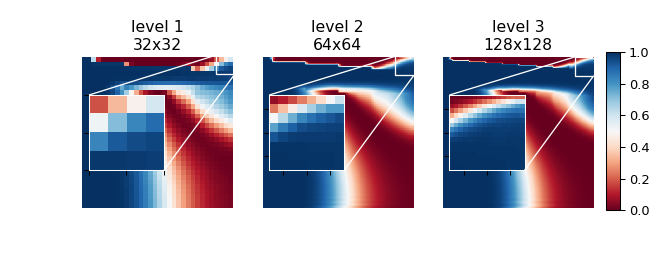

In [8]:
fig, axs = plt.subplots(1,len(levels),figsize=(2.5*len(levels),3) )
extents = [(0,32,0,32),(0,64,0,64), (0,128,0,128)]
zoom_windows = [(28,32,28,32),(56,64,56,64), (112,128,112,128)]
for i,(ax,extent, z_w) in enumerate(zip(axs, extents, zoom_windows)):
    ax.axis('off')
    im = ax.imshow(states_seed[i][-1] , origin='lower', cmap='RdBu', vmin=0, vmax=1)
    axins = zoomed_inset_axes(ax, 4, loc='center left') # zoom = 6
    axins.imshow(states_seed[i][-1], extent=extent, interpolation="nearest", origin="lower", cmap='RdBu')
    # sub region of the original image
    x1, x2, y1, y2 = 15, 20, 15, 20
    axins.set_xlim(z_w[0], z_w[1])
    axins.set_ylim(z_w[2], z_w[3])
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="w")
    axins.spines['bottom'].set_color('w')
    axins.spines['top'].set_color('w') 
    axins.spines['right'].set_color('w')
    axins.spines['left'].set_color('w')
    ax.set_title(titles[i])
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax, orientation="vertical") 
fig.savefig(img_dir+'/s_levels.pdf')

<IPython.core.display.Javascript object>


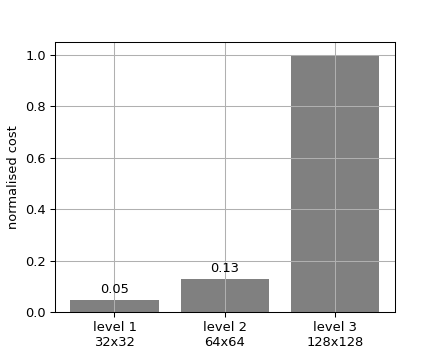

In [6]:
ts = np.array(ts[1:])
fig,axs = plt.subplots(1,1,figsize=(5,4))
avg_t = ts.mean(axis=0)
avg_t = avg_t/avg_t[-1]
axs.bar(titles, avg_t, color='gray', width=0.8 )
axs.grid('on')
for i,t in enumerate(avg_t[:-1]):
    axs.text(i,t+0.04,str(round(t,2)),
            horizontalalignment='center',
            verticalalignment='center')
axs.set_ylabel('normalised cost')
fig.savefig(img_dir+'/t_levels.pdf')

In [7]:
rs=[]

for level in levels:
    rs_l = []
    env_ = deepcopy(env_train_dict[level])
    k_list = env_.ressim_params.k_list
    for k in k_list:
        env_.set_k(np.array([k]))
        states, actions, rewards = eval_actions(env_, actions_)
        rs_l.append(np.sum(rewards))
    rs.append(rs_l)

<IPython.core.display.Javascript object>


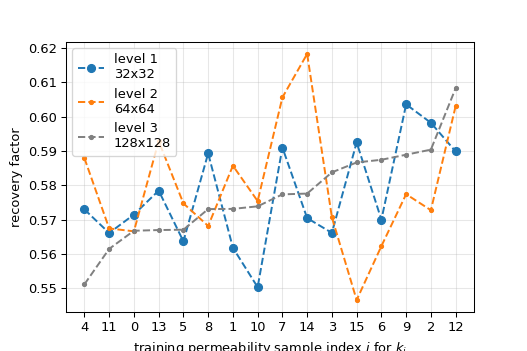

[0.57298779 0.56611966 0.57149133 0.57847191 0.56369258 0.589307
 0.56182273 0.5503551  0.59100931 0.57046661 0.56615865 0.59250008
 0.57000482 0.60356842 0.59821561 0.58985956]
[0.58791461 0.56745671 0.56661516 0.59288854 0.57474769 0.56818086
 0.58571335 0.5754222  0.6055889  0.61825409 0.57069967 0.54661606
 0.56230142 0.57742775 0.57276317 0.60304036]
[0.55119311 0.56150489 0.56678236 0.56698589 0.56708323 0.57308405
 0.5731485  0.57388804 0.57737075 0.57760419 0.58378067 0.58666276
 0.58744251 0.58891727 0.59039077 0.6082531 ]


In [8]:
rs=np.array(rs).reshape(16,-1)
fig,axs = plt.subplots(1,1,figsize=(6,4))
order = np.argsort(rs[:,2])
# order = np.arange(16)

axs.plot( rs[order,0], 'o--')
axs.plot( rs[order,1], '.--')
axs.plot( rs[order,2], '.--', color='gray')
axs.legend(titles)
axs.set_xlabel(r'training permeability sample index $i$ for $k_i$')
axs.set_ylabel('recovery factor')
axs.set_xticks(np.arange(16))
axs.set_xticklabels(order)
axs.grid('on', alpha=0.3)
# fig.savefig(data_dir+'/'+case_label+'_r_comparison.pdf')
fig.show()

print(rs[order,0])
print(rs[order,1])
print(rs[order,2])